<a href="https://colab.research.google.com/github/bres/PytorchStudy/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# convert mnist image files in to ternsor of 4 dimensions (number of images,height,witdh,color channel)
transform = transforms.ToTensor()

In [ ]:
# Train our data
train_data = datasets.MNIST(root='cnn_data',train=True,download=True,transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.31MB/s]


In [ ]:
# Test data
test_data = datasets.MNIST(root='cnn_data',train=False,download=True,transform=transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
# create a small batch size for images
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)


In [11]:
# define our cnn model
# describe cnn layer (2 cnn layers)
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)

In [12]:
# grab mnist recors
for i, (X_train, y_train) in enumerate(train_data):
    break

In [14]:
X_train.shape


torch.Size([1, 28, 28])

In [18]:
x = X_train.view(1,1,28,28)

In [19]:
# perform our first convolution layer
x =F.relu(conv1(x)) # Rectified linear unit

In [21]:
# 1 image, 6 filters,26x26 with auto-padding
x.shape


torch.Size([1, 6, 26, 26])

In [22]:
# pass thru the pooling layer
x =F.max_pool2d(x,kernel_size=2,stride=2)

In [23]:
x.shape

torch.Size([1, 6, 13, 13])

In [24]:
# second convolutional layer
x =F.relu(conv2(x))

In [25]:
x.shape

torch.Size([1, 16, 11, 11])

In [26]:
# Pooling layer
x =F.max_pool2d(x,kernel_size=2,stride=2)

In [27]:
x.shape

torch.Size([1, 16, 5, 5])

In [28]:
# model class
class convolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)
    self.Conv2d = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,X):
    X =F.relu(self.conv1(X))
    X =F.max_pool2d(X,kernel_size=2,stride=2)
    # second pass
    X =F.relu(self.Conv2d(X))
    X =F.max_pool2d(X,kernel_size=2,stride=2)
    # flatten
    X = X.view(-1,5*5*16)
    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [29]:
# create an instance of our model
torch.manual_seed(41)
model = convolutionalNetwork()
model


convolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (Conv2d): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [30]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [31]:
import time
start_time = time.time()
# create variables to track things

epochs =5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop for epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  # train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #start our batches in 1
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)
    predicted = torch.max(y_pred.data,1)[1] # the number of correct predictions
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch
    trn_corr += batch_corr
  # update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # print results
    if b%600 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_corr)

  # test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)
  # update our lists


current_time = time.time()
total_time = current_time-start_time
print(f'training took : {total_time/60} minutes!')


epoch: 0  batch: 600  loss: 0.1623610556125641
epoch: 0  batch: 1200  loss: 0.1502392590045929
epoch: 0  batch: 1800  loss: 0.4744560718536377
epoch: 0  batch: 2400  loss: 0.14238706231117249
epoch: 0  batch: 3000  loss: 0.007758188061416149
epoch: 0  batch: 3600  loss: 0.3836284875869751
epoch: 0  batch: 4200  loss: 0.0038223876617848873
epoch: 0  batch: 4800  loss: 0.0021286322735249996
epoch: 0  batch: 5400  loss: 0.0569545142352581
epoch: 0  batch: 6000  loss: 0.00038789428072050214
epoch: 1  batch: 600  loss: 0.005851339548826218
epoch: 1  batch: 1200  loss: 0.3855525553226471
epoch: 1  batch: 1800  loss: 0.004819948226213455
epoch: 1  batch: 2400  loss: 0.003216963727027178
epoch: 1  batch: 3000  loss: 0.0332382395863533
epoch: 1  batch: 3600  loss: 0.5372857451438904
epoch: 1  batch: 4200  loss: 0.04561494290828705
epoch: 1  batch: 4800  loss: 0.0007510822033509612
epoch: 1  batch: 5400  loss: 0.0001173773780465126
epoch: 1  batch: 6000  loss: 0.14201366901397705
epoch: 2  batch

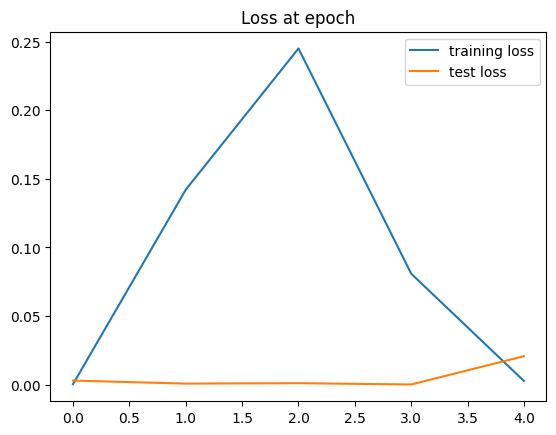

In [33]:
# graph loss in each epoch
train_losses = torch.tensor(train_losses)
test_losses = torch.tensor(test_losses)
plt.plot(train_losses,label='training loss')
plt.plot(test_losses,label='test loss')
plt.title('Loss at epoch')
plt.legend()

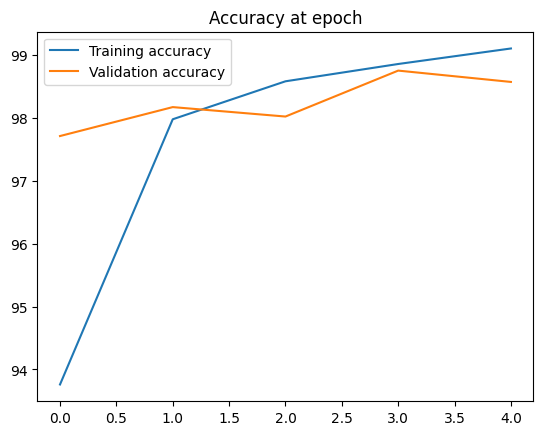

In [35]:
# graph the accuracy
plt.plot([t/600 for t in train_correct],label="Training accuracy")
plt.plot([t/100 for t in test_correct],label="Validation accuracy")
plt.title('Accuracy at epoch')
plt.legend()

In [36]:
test_load_everything =DataLoader(test_data,batch_size=10000,shuffle=False)

In [38]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data,1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test accuracy: {correct.item()/10000}')

Test accuracy: 0.9857


In [41]:
# grab an image
#test_data[4143] # tensor with an image
# grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [42]:
# reshape
test_data[4143][0].view(1,1,28,28).shape

torch.Size([1, 1, 28, 28])

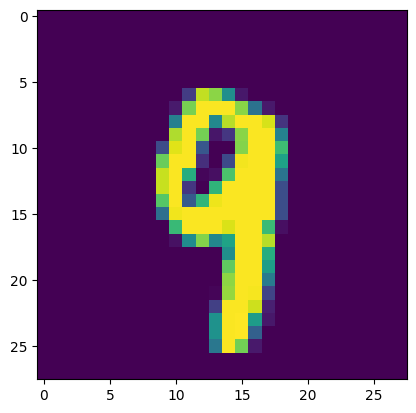

In [43]:
# show the image
plt.imshow(test_data[4143][0].view(28,28))

In [46]:
# ppas the image tru the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28))


In [49]:
# chek the prediction
new_prediction.argmax()

tensor(9)